In [2]:
pip install torch imblearn numpy pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Vishal Kumar\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


Using device: cpu
Dataset loaded successfully
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 

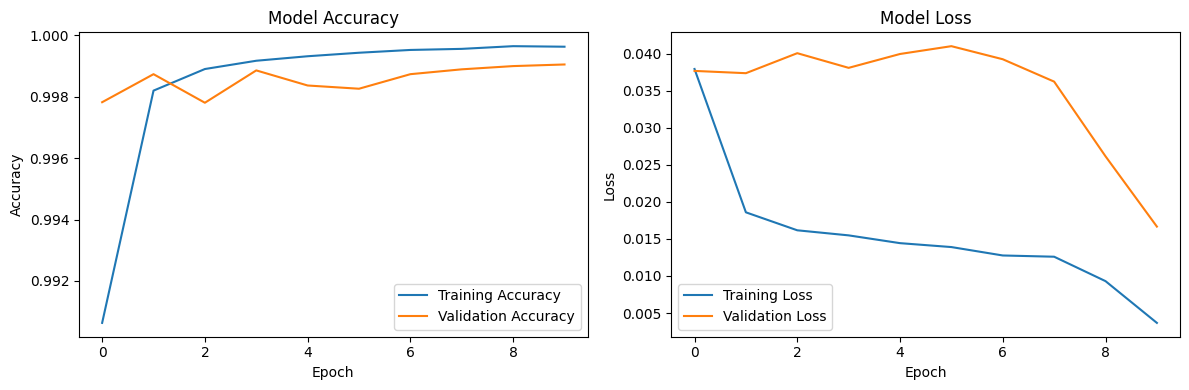

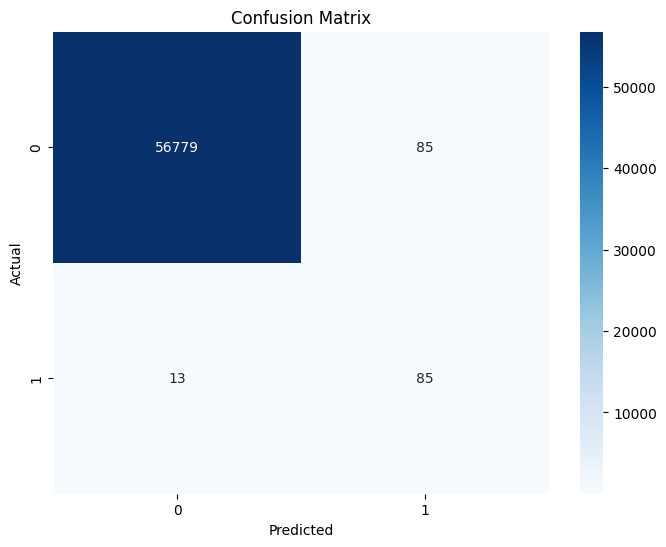

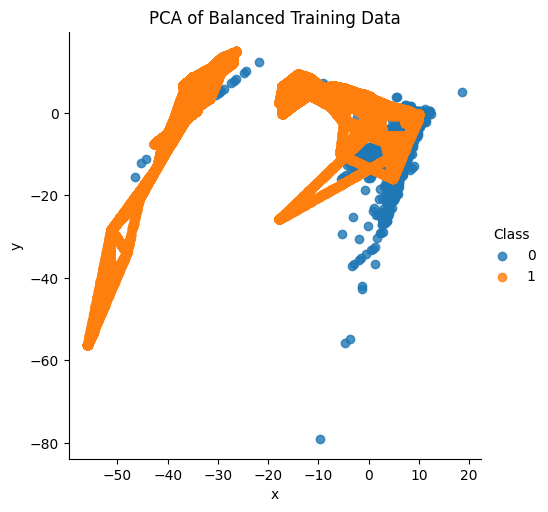

In [6]:
# Importing Libraries
import numpy as np
import pandas as pd
from math import sqrt
import sklearn.utils
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loading Data
creditcard_data = pd.read_csv("Documents/Intern/creditcard.csv")
print("Dataset loaded successfully")
print(creditcard_data.head())

# Data Preprocessing
# Dropping Time feature as it provides no useful information
creditcard_data = creditcard_data.drop("Time", axis=1)

# Standardizing the Amount column
Rob_scaler = RobustScaler()
creditcard_data['Std_Amount'] = Rob_scaler.fit_transform(creditcard_data['Amount'].values.reshape(-1, 1))
creditcard_data = creditcard_data.drop('Amount', axis=1)

# Move Std_Amount to the first column
Std_Amount = creditcard_data['Std_Amount']
creditcard_data.drop('Std_Amount', axis=1, inplace=True)
creditcard_data.insert(0, 'Std_Amount', Std_Amount)
print("\nPreprocessed dataset:")
print(creditcard_data.head())

# Splitting Data
X = creditcard_data.drop('Class', axis=1)
Y = creditcard_data['Class']

# Split into train (80%) and test (20%)
sss1 = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index1, test_index in sss1.split(X, Y):
    Xtrain, Xtest = X.iloc[train_index1], X.iloc[test_index]
    Ytrain, Ytest = Y.iloc[train_index1], Y.iloc[test_index]
    break  # Take the first split

# Split train set into train (60%) and validation (20%)
sss2 = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
for train_index2, val_index in sss2.split(Xtrain, Ytrain):
    Xtrain_final, Xval = Xtrain.iloc[train_index2], Xtrain.iloc[val_index]
    Ytrain_final, Yval = Ytrain.iloc[train_index2], Ytrain.iloc[val_index]
    break  # Take the first split

# Check label distributions
train_unique_label, train_counts_label = np.unique(Ytrain_final, return_counts=True)
test_unique_label, test_counts_label = np.unique(Ytest, return_counts=True)
val_unique_label, val_counts_label = np.unique(Yval, return_counts=True)
print('\nLabel Distributions:')
print('Train:', train_counts_label / len(Ytrain_final))
print('Test:', test_counts_label / len(Ytest))
print('Validation:', val_counts_label / len(Yval))

# Verify dataset shapes
print("\nDataset shapes:")
print("Xtrain_final:", Xtrain_final.shape)
print("Ytrain_final:", Ytrain_final.shape)
print("Xtest:", Xtest.shape)
print("Ytest:", Ytest.shape)
print("Xval:", Xval.shape)
print("Yval:", Yval.shape)

# Reshaping Data for LSTM
# LSTM expects 3D input: (samples, timesteps, features)
n_features = Xtrain_final.shape[1]  # 29 features
timesteps = 1  # Each sample is treated as one timestep

Xtrain_reshaped = Xtrain_final.values.reshape(-1, timesteps, n_features)
Xval_reshaped = Xval.values.reshape(-1, timesteps, n_features)
Xtest_reshaped = Xtest.values.reshape(-1, timesteps, n_features)

print("\nReshaped dataset shapes:")
print("Training set shape:", Xtrain_reshaped.shape)
print("Validation set shape:", Xval_reshaped.shape)
print("Test set shape:", Xtest_reshaped.shape)

# Applying SMOTE for Balancing
# SMOTE needs 2D input, so reshape back temporarily
Xtrain_2d = Xtrain_reshaped.reshape(Xtrain_reshaped.shape[0], -1)
smote = SMOTE(random_state=42)
Xtrain_smote, Ytrain_smote = smote.fit_resample(Xtrain_2d, Ytrain_final)

# Reshape SMOTE data back to 3D for LSTM
Xtrain_smote_reshaped = Xtrain_smote.reshape(-1, timesteps, n_features)
print("\nSMOTE balanced training set shape:", Xtrain_smote_reshaped.shape)
print("SMOTE balanced class distribution:", Counter(Ytrain_smote))

# Convert to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain_smote_reshaped, dtype=torch.float32).to(device)
Ytrain_tensor = torch.tensor(Ytrain_smote, dtype=torch.float32).reshape(-1, 1).to(device)
Xval_tensor = torch.tensor(Xval_reshaped, dtype=torch.float32).to(device)
Yval_tensor = torch.tensor(Yval.values, dtype=torch.float32).reshape(-1, 1).to(device)
Xtest_tensor = torch.tensor(Xtest_reshaped, dtype=torch.float32).to(device)
Ytest_tensor = torch.tensor(Ytest.values, dtype=torch.float32).reshape(-1, 1).to(device)

# Create DataLoader for batch processing
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
val_dataset = TensorDataset(Xval_tensor, Yval_tensor)
test_dataset = TensorDataset(Xtest_tensor, Ytest_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Defining Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, timesteps, hidden_dim)
        attention_weights = torch.softmax(self.attention(lstm_output).squeeze(-1), dim=1)
        # attention_weights: (batch_size, timesteps)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)
        # context_vector: (batch_size, hidden_dim)
        return context_vector, attention_weights

# Defining LSTM Model with Attention
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_rate=0.3):
        super(LSTMAttentionModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.attention = Attention(hidden_dim2)
        self.fc1 = nn.Linear(hidden_dim2 * 2, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, timesteps, input_dim)
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        context_vector, attention_weights = self.attention(lstm_out2)
        # Concatenate LSTM output and context vector
        lstm_last = lstm_out2[:, -1, :]  # Take the last timestep
        combined = torch.cat((lstm_last, context_vector), dim=1)
        out = self.fc1(combined)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

# Initialize model
model = LSTMAttentionModel(input_dim=n_features).to(device)
print(model)

# Training Setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = (output >= 0.5).float()
        correct += (pred == target).sum().item()
        total += target.size(0)
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    outputs = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            pred = (output >= 0.5).float()
            correct += (pred == target).sum().item()
            total += target.size(0)
            outputs.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    roc_auc = roc_auc_score(targets, outputs)
    return epoch_loss, epoch_acc, roc_auc

# Training Loop
num_epochs = 10
best_val_auc = 0.0
patience = 5
counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_auc = validate_epoch(model, val_loader, criterion)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
    
    # Early stopping
    if counter >= patience:
        print("Early stopping triggered")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluation on Test Set
def evaluate_model(model, loader):
    model.eval()
    outputs = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            outputs.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    outputs = np.array(outputs)
    targets = np.array(targets)
    predictions = (outputs >= 0.5).astype(int)
    return predictions, targets, outputs

# Get predictions
Ypred, Ytest_np, Ypred_proba = evaluate_model(model, test_loader)

# Print classification report
print("\nClassification Report:")
print(classification_report(Ytest_np, Ypred))

# Calculate ROC AUC
roc_auc = roc_auc_score(Ytest_np, Ypred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Visualizing Results
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(Ytest_np, Ypred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualizing Balanced Dataset (Optional)
# Apply PCA for visualization
pca = PCA(n_components=2)
X_smote_2d = Xtrain_smote_reshaped.reshape(Xtrain_smote_reshaped.shape[0], -1)
train_2d = pd.DataFrame(pca.fit_transform(X_smote_2d))
train_2d = pd.concat([train_2d, pd.DataFrame(Ytrain_smote, columns=['Class'])], axis=1)
train_2d.columns = ['x', 'y', 'Class']
sns.lmplot(x='x', y='y', data=train_2d, fit_reg=False, hue='Class')
plt.title('PCA of Balanced Training Data')
plt.show()